In [1]:
# step 1

!pip install Pillow
# mount_drive.py
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# Updated step 2: Adding data augmentation
def prepare_data_generators(train_path, val_path, test_path, target_size=(256, 256), batch_size=32):
    from tensorflow.keras.preprocessing.image import ImageDataGenerator

    train_datagen = ImageDataGenerator(
        rescale=1.0/255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )
    val_datagen = ImageDataGenerator(rescale=1.0/255)
    test_datagen = ImageDataGenerator(rescale=1.0/255)

    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    val_generator = val_datagen.flow_from_directory(
        val_path,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    return train_generator, val_generator, test_generator

In [3]:
# Updated step 3: Using pretrained model with fine-tuning
def build_model(input_shape=(256, 256, 3), num_classes=4):
    from tensorflow.keras.applications import VGG16
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
    from tensorflow.keras.optimizers import Adam

    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model

    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [66]:
# Updated step 4: Add early stopping and learning rate scheduler
def train_model(model, train_generator, val_generator, epochs=10):
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=val_generator,
        callbacks=[early_stopping, lr_scheduler]
    )
    return history

In [67]:
# Updated step 5: Improved visualization
def evaluate_and_visualize(model, test_generator, history):
    import matplotlib.pyplot as plt

    # Evaluate on the test dataset
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

    # Plot training and validation accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [68]:
# Step 6: Preprocess image for prediction
def preprocess_image(image_path, target_size=(256, 256)):
    """
    Preprocesses a single image for prediction.
    """
    import numpy as np
    from tensorflow.keras.utils import load_img, img_to_array

    img = load_img(image_path, target_size=target_size)
    x = img_to_array(img) / 255.0
    x = np.expand_dims(x, axis=0)  # Add batch dimension
    return x


In [69]:
# Updated step 7: Custom breed names
def predict_image(model, image_path, class_indices, target_size=(256, 256)):
    """
    Predicts the class of a given image using the trained model.
    """
    import numpy as np  # Ensure numpy is imported
    x = preprocess_image(image_path, target_size)
    predictions = model.predict(x)
    predicted_label = np.argmax(predictions)

    # Mapping predicted index to breed names
    breed_names = {
        0: "New Hampshire Red",
        1: "Black Sussex Hybrid",
        2: "Swedish Flower",
        3: "Local Chicken"
    }

    return breed_names[predicted_label]



In [70]:
# Step 8: Mount Google Drive
def mount_drive():
    """
    Mounts Google Drive to access the dataset.
    """
    import numpy as np
    from google.colab import drive
    drive.mount('/content/drive')
    !ls /content/drive/MyDrive
mount_drive()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'20233 4CM FinalQuestion.gdoc'
'454 copy.jpg'
 C221115_CSE-3637.pdf
 C221115_ECON-3501.pdf
 C221115_ECON_ASSIGNMENT.pdf
 C221115_ECON_CT-2.pdf
 C221115_EEE-2421_ASSIGNMENT.pdf
'C221115_MATH ASSIGNMENT.pdf'
'C221115_Md Farhan Uddin_RESUME.pdf'
 C221115_MDP-3606_CT-2.pdf
'C221115_NEWCOMERS SHEET.pdf'
'C221115_NEWCOMERS SHEET_SS.pdf'
'CamScanner 02-11-2022 11.47.pdf'
 chat.txt
'Chicken Breed Recognition'
 chicken-photos-master
 Classroom
'Colab Notebooks'
'Copy of C221115_CSE-3637.pdf'
'EEE-1121_Mid Question Spr-22.gdoc'
 Farhan_Experience.pdf
"Farhan's Copy Of JTS.gsheet"
'IMG_20210211_122225 (1).jpg'
 IMG_20210211_122225.jpg
'Java Lab.gdoc'
'LAB Report 2 - Study of Basic DC circuit using PSpice.pdf'
'Lecture 28 CRC with example.gdoc'
'Md Farhan Uddin Rifat Rifat C221115.pdf'
'Mid-Admit-Card-C221115-78 (2).pdf'
 Mid-Exam-Cover-Page.docx
'mmq-dapq-yye - Oct 24, 

In [78]:
# Step 8: Define dataset paths
train_path = "/content/drive/MyDrive/Chicken Breed Recognition/Train"
val_path = "/content/drive/MyDrive/Chicken Breed Recognition/Validation"
test_path = "/content/drive/MyDrive/Chicken Breed Recognition/Test"



In [79]:
# Step 9: Prepare data generators
train_generator, val_generator, test_generator = prepare_data_generators(train_path, val_path, test_path)



Found 144 images belonging to 4 classes.
Found 48 images belonging to 4 classes.
Found 48 images belonging to 4 classes.


In [80]:
# Step 10: Build and compile the model
model = build_model(input_shape=(256, 256, 3), num_classes=4)


In [74]:
# Step 11: Train the model
history = train_model(model, train_generator, val_generator, epochs=10)


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 170s 38s/step - accuracy: 0.4019 - loss: 1.7104 - val_accuracy: 0.6458 - val_loss: 0.8242 - learning_rate: 1.0000e-04
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 202s 34s/step - accuracy: 0.7152 - loss: 0.7460 - val_accuracy: 0.8958 - val_loss: 0.4053 - learning_rate: 1.0000e-04
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 164s 33s/step - accuracy: 0.8336 - loss: 0.3430 - val_accuracy: 0.9583 - val_loss: 0.2253 - learning_rate: 1.0000e-04
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 166s 34s/step - accuracy: 0.9668 - loss: 0.1223 - val_accuracy: 0.9583 - val_loss: 0.1477 - learning_rate: 1.0000e-04
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 244s 44s/step - accuracy: 0.9583 - loss: 0.1318 - val_accuracy: 0.9583 - val_loss: 0.1145 - learning_rate: 1.0000e-04
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 163s 33s/step - accuracy: 0.9590 - loss: 0.0926 - val_accuracy: 0.9792 - val_loss: 0.0938 - learning_rate: 1.0000e-04
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 163s 33s/step - accuracy: 0.9627 - loss:

2/2 ━━━━━━━━━━━━━━━━━━━━ 42s 15s/step - accuracy: 0.9760 - loss: 0.0585
Test Loss: 0.05560814216732979
Test Accuracy: 97.96%


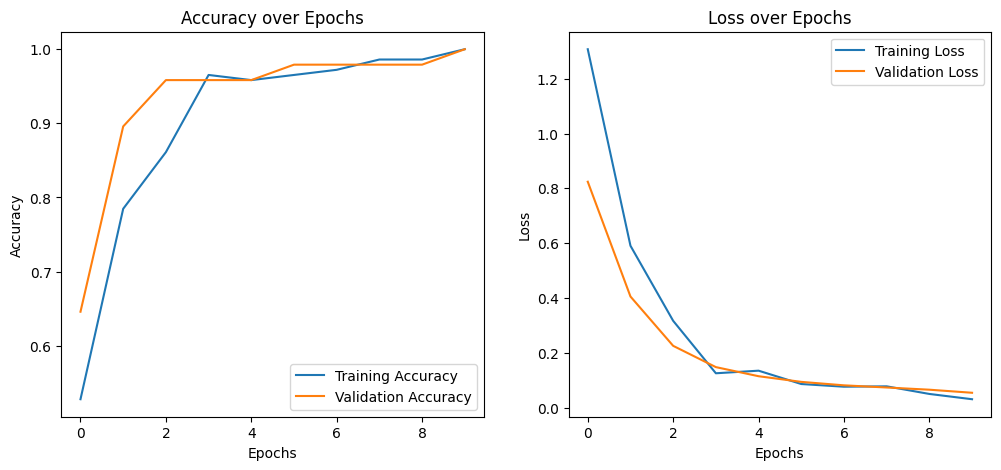

In [75]:
# Step 12: Evaluate the model
evaluate_and_visualize(model, test_generator, history)

In [76]:
# step 13 : Predict a sample image
test_image_path = "/content/drive/MyDrive/Chicken Breed Recognition/Test/2/203.jpg"
class_indices = train_generator.class_indices
predicted_breed = predict_image(model, test_image_path, class_indices)
print(f"Predicted Breed: {predicted_breed}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 920ms/step
Predicted Breed: Black Sussex Hybrid


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step


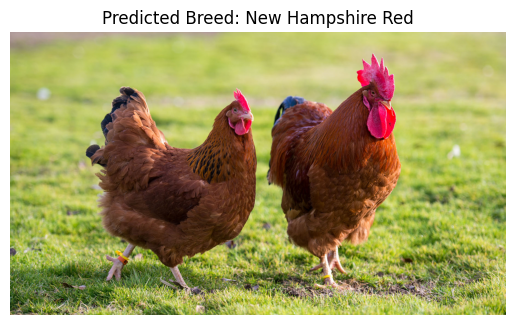

Predicted Breed: New Hampshire Red


In [77]:
# step 13 : Predict a sample image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

# Updated predict_image function
def predict_image(model, image_path, class_indices, target_size=(256, 256)):
    """
    Predicts the breed of a chicken from an input image and displays the image with the prediction.

    Args:
    - model: Trained model.
    - image_path: Path to the input image.
    - class_indices: Mapping of class indices to class labels.
    - target_size: Tuple, target resolution for the image (default is 256x256).

    Returns:
    - Predicted breed name.
    """
    # Load and preprocess the image
    img = load_img(image_path, target_size=target_size)  # Resize to target_size
    img_array = img_to_array(img) / 255.0               # Normalize pixel values to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)       # Add batch dimension for the model

    # Make predictions
    predictions = model.predict(img_array)
    predicted_label = np.argmax(predictions)  # Get the class index with highest probability

    # Map the predicted index to the breed name
    breed_names = {v: k for k, v in class_indices.items()}  # Reverse the class_indices mapping
    breed_names = {
        0: "New Hampshire Red",
        1: "Black Sussex Hybrid",
        2: "Swedish Flower",
        3: "Local Chicken"
    }
    predicted_breed = breed_names[predicted_label]


    # Display the image with the predicted breed
    plt.imshow(load_img(image_path))
    plt.title(f"Predicted Breed: {predicted_breed}")
    plt.axis("off")
    plt.show()


    return predicted_breed

# Step 14: Predict a sample image
test_image_path = "/content/drive/MyDrive/Chicken Breed Recognition/Random Test/10.jpg"  # Replace with your test image path
class_indices = train_generator.class_indices  # From your data generators

# Predict and display the test image with breed name
predicted_breed = predict_image(model, test_image_path, class_indices)
print(f"Predicted Breed: {predicted_breed}")
